# Analyse des tweets et articles pour la prédiction de la performance et volatilité du SP500

**Projet Python - 2A ENSAE** . 

Elena Loumagne / Jérémie Darracq 

## Introduction 

Objectifs : il s'agit de conduire une analyse de sentiments des tweets et des articles US en lien avec le SP500 pour proposer une modèle de prédiction sur la performance et la volatilité du SP500. 

Projet : il se découpe en trois parties 

- 1ère partie (voir notebook_récup_data_webscrapping /notebook_récup_data_API_finhub) : l'extraction des données sur la performance du SP500 (indice de performance SP500) et sa volatilité (indice VIX). La récupération des articles et des tweets en lien avec le SP500 via les API.   

- 2ème partie (notebook_récup_data_API_finhub) : le traitement des données incluant le nettoyage des tweets et des articles. 

- 3ème partie (notebook_analyse_data) : l'analyse des données par des statistiques descriptives, l'analyse de sentiment et construction du modèle de prédiction. 




## Sources

- Pour l'API finhub : https://python.plainenglish.io/access-historical-financial-news-headlines-with-python-be1b8faaea9f      
- Pour l'API twitter : https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178    
- Pour la prédiction : https://sentometrics-research.com/sentometrics/articles/applications/vix.html​




## Definitions 

- SP500 : indice boursier basé sur 500 grandes sociétés cotées sur les bourses aux États-Unis (NYSE ou NASDAQ). Il couvre environ 80 % du marché boursier américain par sa capitalisation.    
-  indice VIX : indicateur de volatilité du marché financier établit par le Chicago Board option Exchange.Le cours des options est considéré comme une bonne mesure de la volatilité car si quelque chose suscite de l’inquiétude sur le marché, les traders et les investisseurs ont tendance à se positionner à l’achat sur les options, ce qui entraîne une hausse des cours. C’est la raison pour laquelle le VIX est également appelé « indice de la peur », puisqu’il mesure le niveau de peur et de stress sur le marché.

- FINHUB : API fournissant des données financières et articles concernant les plus grandes entreprises mondiales. 

## Import des packages 

In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import imshow
import scipy
from scipy.stats import chi2_contingency as chi2_contingency



## I - Exploration et analyse des données 

In [37]:
## On importe les articles propres 
article_data = pd.read_csv("Data/data_finhub.csv")

### Statistiques descriptives de la base d'articles financiers 

In [3]:
article_data.groupby("source")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()


,27,19,14,4,11,18,24,1,25,12,...,13,17,5,10,26,23,16,8,0,9
source,Yahoo,SeekingAlpha,MarketWatch,CNBC,GuruFocus,Reuters,Thefly.com,Alliance News,TipRanks,InvestorPlace,...,Market News Video,Preferred Stock Channel,Dividend Channel,GlobeNewswire,United Press International,The Online Investor,PennyStocks,Finnhub,Accesswire,Fintel
abstract,5568,1737,1302,489,424,332,290,130,104,90,...,8,7,7,6,6,3,2,1,1,0


In [4]:
article_data.groupby("company")["abstract"].count().reset_index().sort_values(by="abstract",ascending=False).transpose()

,21,30,15,37,24,44,4,35,25,11,...,46,47,40,43,41,18,34,14,3,13
company,GOOGL,META,COST,NVDA,INTC,TSLA,AMZN,NFLX,JNJ,BRK.B,...,VZ,WFC,PM,TMUS,SLB,EA,NDAQ,COF,AIG,CBOE
abstract,243,243,243,242,242,240,239,238,237,236,...,219,219,209,207,202,121,118,111,90,88


Des tableaux ci-dessus on constate que : 
- nos articles proviennent majoritairement des site Yahoo, SeekingAlpha et MarketWatch
- Les entreprises les plus citées sont Google et Méta mais les nombres de citations pour chaque entreprise est assez similaire

### Calcul du sentiment des articles à partir de la polarité

Ceci est fait grâce au package **SentimentIntensityAnalyzer** qui renvoie la polarité positive pour un sentiment positif, nulle pour un sentiment neutre et négative pour un sentiment négatif.

In [5]:
sia = SentimentIntensityAnalyzer() # analiseur des sentiments


# ajout de mots spécifiques à la finance au lexique : moyenne du score de sentiment entre -4 (très négatif) et 4 (très positif)

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_words = {**dictOfpos, **dictOfneg} # déballage du dictionnaire

sia.lexicon.update(Financial_words)

In [6]:
article_data

,date,headline,company,abstract,source,abstract_clean,abstract_stemmed
0,12/05/22,"Why Amazon, Okta, and Roku Stocks All Slumped ...",AMZN,A report on the state of the service sector fu...,Yahoo,report state service sector fueled fears feder...,report state servic sector fuel fear feder res...
1,12/05/22,Apple and Amazon resume Twitter advertising,AMZN,Yahoo Finance tech editor Dan Howley outlines ...,Yahoo,yahoo finance tech editor dan howley outlines ...,yahoo financ tech editor dan howley outlin app...
2,12/05/22,"Amazon's (AMZN) AWS Gets Selected by Yahoo, Bo...",AMZN,Amazon's (AMZN) AWS is chosen by Yahoo as the ...,Yahoo,amazon (amzn) aws chosen yahoo preferred publi...,amazon (amzn) aw chosen yahoo prefer public cl...
3,12/05/22,Amazon.com Inc. stock underperforms Monday whe...,AMZN,Shares of Amazon.com Inc. shed 3.31% to $91.01...,MarketWatch,"shares amazoncom inc shed $ monday, proved all...","share amazoncom inc shed $ monday, prove all-a..."
4,12/05/22,"After explosive growth, Philadelphia tech star...",AMZN,"Triumph Technology Solutions, which has experi...",Yahoo,"triumph technology solutions, experienced year...","triumph technolog solutions, experienc year-ov..."
...,...,...,...,...,...,...,...
10833,10/06/22,Former Amazon cloud engineer gets probation fo...,COF,"The hack compromised about 140,000 Social Secu...",Yahoo,"hack compromised , social security numbers , b...","hack compromis , social secur number , bank ac..."
10834,10/05/22,Capital One Financial Corporation to Webcast C...,COF,"On Thursday, October 27, 2022, at approximatel...",Yahoo,"thursday, october , , approximately : pm easte...","thursday, octob , , approxim : pm eastern time..."
10835,10/04/22,Why Is RIVN Stock Up Today? Rivian Confirmed 2...,COF,RIVN stock is up after Rivian announced it pro...,InvestorPlace,"rivn stock rivian announced produced , vehicle...","rivn stock rivian announc produc , vehicl trac..."
10836,10/03/22,"Q3 2022 Bank Analysts' Top 3 Picks, Earnings E...",COF,"Big bank stocks are down 27% on average, but a...",SeekingAlpha,"big bank stocks average, analysts see sunny da...","big bank stock average, analyst see sunni day ..."


In [7]:
## On calcul le sentiment des résumés de chaque articles 
article_data["sentiment_score_abstract"]=article_data["abstract_stemmed"].apply(lambda x: sia.polarity_scores(str(x))['compound'])


Nous codifions donc par -1 tout sentiment négatif, par 0 tout sentiment neutre et par 1 tout sentiment positif. Les fonctions suivantes sont écrites à cet effet :

In [8]:
def article_label(score):
    if score > 0.00 :
        return "positif"
    if score < 0.00 :
        return "negatif"
    else :
        return "neutre"

def article_label_score(score):
    if score > 0.00 :
        return 1
    if score < 0.00 :
        return -1
    else :
        return 0

article_data["label_abstract"]=article_data["sentiment_score_abstract"].apply(article_label)
article_data["label_score_abstract"]=article_data["sentiment_score_abstract"].apply(article_label_score)
article_data


,date,headline,company,abstract,source,abstract_clean,abstract_stemmed,sentiment_score_abstract,label_abstract,label_score_abstract
0,12/05/22,"Why Amazon, Okta, and Roku Stocks All Slumped ...",AMZN,A report on the state of the service sector fu...,Yahoo,report state service sector fueled fears feder...,report state servic sector fuel fear feder res...,0.8126,positif,1
1,12/05/22,Apple and Amazon resume Twitter advertising,AMZN,Yahoo Finance tech editor Dan Howley outlines ...,Yahoo,yahoo finance tech editor dan howley outlines ...,yahoo financ tech editor dan howley outlin app...,0.1779,positif,1
2,12/05/22,"Amazon's (AMZN) AWS Gets Selected by Yahoo, Bo...",AMZN,Amazon's (AMZN) AWS is chosen by Yahoo as the ...,Yahoo,amazon (amzn) aws chosen yahoo preferred publi...,amazon (amzn) aw chosen yahoo prefer public cl...,0.1779,positif,1
3,12/05/22,Amazon.com Inc. stock underperforms Monday whe...,AMZN,Shares of Amazon.com Inc. shed 3.31% to $91.01...,MarketWatch,"shares amazoncom inc shed $ monday, proved all...","share amazoncom inc shed $ monday, prove all-a...",0.2960,positif,1
4,12/05/22,"After explosive growth, Philadelphia tech star...",AMZN,"Triumph Technology Solutions, which has experi...",Yahoo,"triumph technology solutions, experienced year...","triumph technolog solutions, experienc year-ov...",0.9260,positif,1
...,...,...,...,...,...,...,...,...,...,...
10833,10/06/22,Former Amazon cloud engineer gets probation fo...,COF,"The hack compromised about 140,000 Social Secu...",Yahoo,"hack compromised , social security numbers , b...","hack compromis , social secur number , bank ac...",0.0516,positif,1
10834,10/05/22,Capital One Financial Corporation to Webcast C...,COF,"On Thursday, October 27, 2022, at approximatel...",Yahoo,"thursday, october , , approximately : pm easte...","thursday, octob , , approxim : pm eastern time...",0.7184,positif,1
10835,10/04/22,Why Is RIVN Stock Up Today? Rivian Confirmed 2...,COF,RIVN stock is up after Rivian announced it pro...,InvestorPlace,"rivn stock rivian announced produced , vehicle...","rivn stock rivian announc produc , vehicl trac...",0.0000,neutre,0
10836,10/03/22,"Q3 2022 Bank Analysts' Top 3 Picks, Earnings E...",COF,"Big bank stocks are down 27% on average, but a...",SeekingAlpha,"big bank stocks average, analysts see sunny da...","big bank stock average, analyst see sunni day ...",0.0000,neutre,0


#### Statistiques descriptives du sentiment des articles 

<AxesSubplot:xlabel='label_abstract', ylabel='Count'>

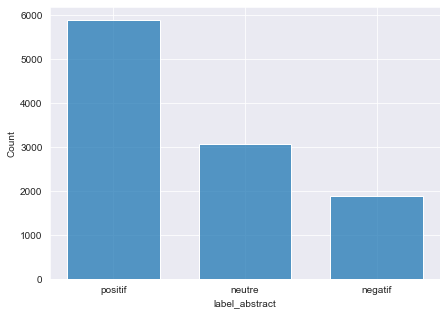

In [9]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
sns.histplot(article_data.sort_values("label_abstract", ascending=False), x="label_abstract",  shrink=0.7)


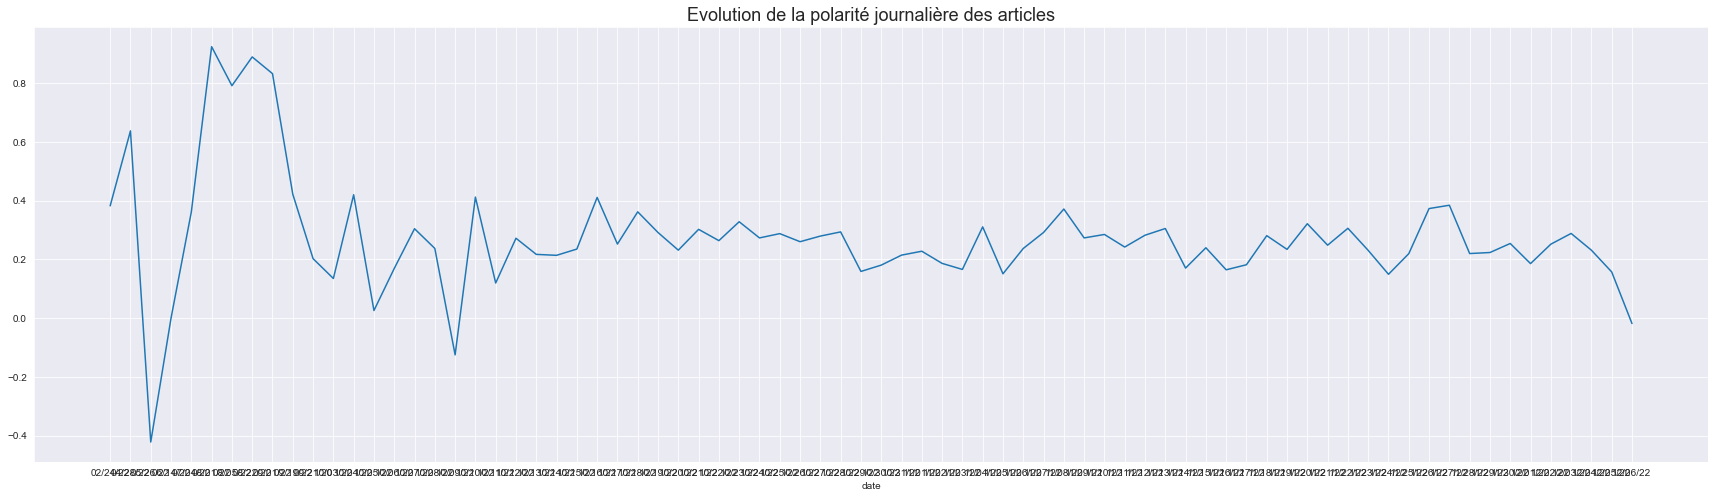

In [10]:
# Evolution de la polarité journalière des articles entre du 01 octobre 2022 au 5 décembre 2022
plt.figure(figsize=(30, 8))
plt.xlabel('date')
df2 = article_data[['date','sentiment_score_abstract']].groupby('date').mean()

plt.plot(df2)

plt.title("Evolution de la polarité journalière des articles", size=18)
plt.show()

Des tableaux ci-dessus on constate que : 
- Il y a environ 3 fois plus d'articles positifs que négatifs et 2 fois plus d'articles positifs que neutres. 
- En moyenne, la polarité est au dessus de 0, passant largement en dessous début octobre.  Ce qui exprime la négativité dans les commentaires au cours de ces périodes. En mi Décembre, cette polarité passe à 0,4 au cours d'un jour donnée (polarité journalière moyenne la plus élevée sur toute la période), ce qui exprime une positivité des commentaires ce jour.


A faire :   
-  relation entre le type de sentiment et chaque entreprise + test pour voir si le type de sentiment est indépendant de l'entreprise ==> permet de savoir si le sentiment sur l'entreprise est plutôt lié à la bonne tenue de l'entreprise ou au sentiment globale du marché 
-  revoir les dates sur le graphique 
- regresser les valeurs des indices sur le sentiment des articles + improve modèle avec les tweet 



### Relation entre le type de sentiment et les entreprises

In [11]:
cont=pd.crosstab(article_data["label_abstract"],article_data["company"])


<Figure size 7200x7200 with 0 Axes>

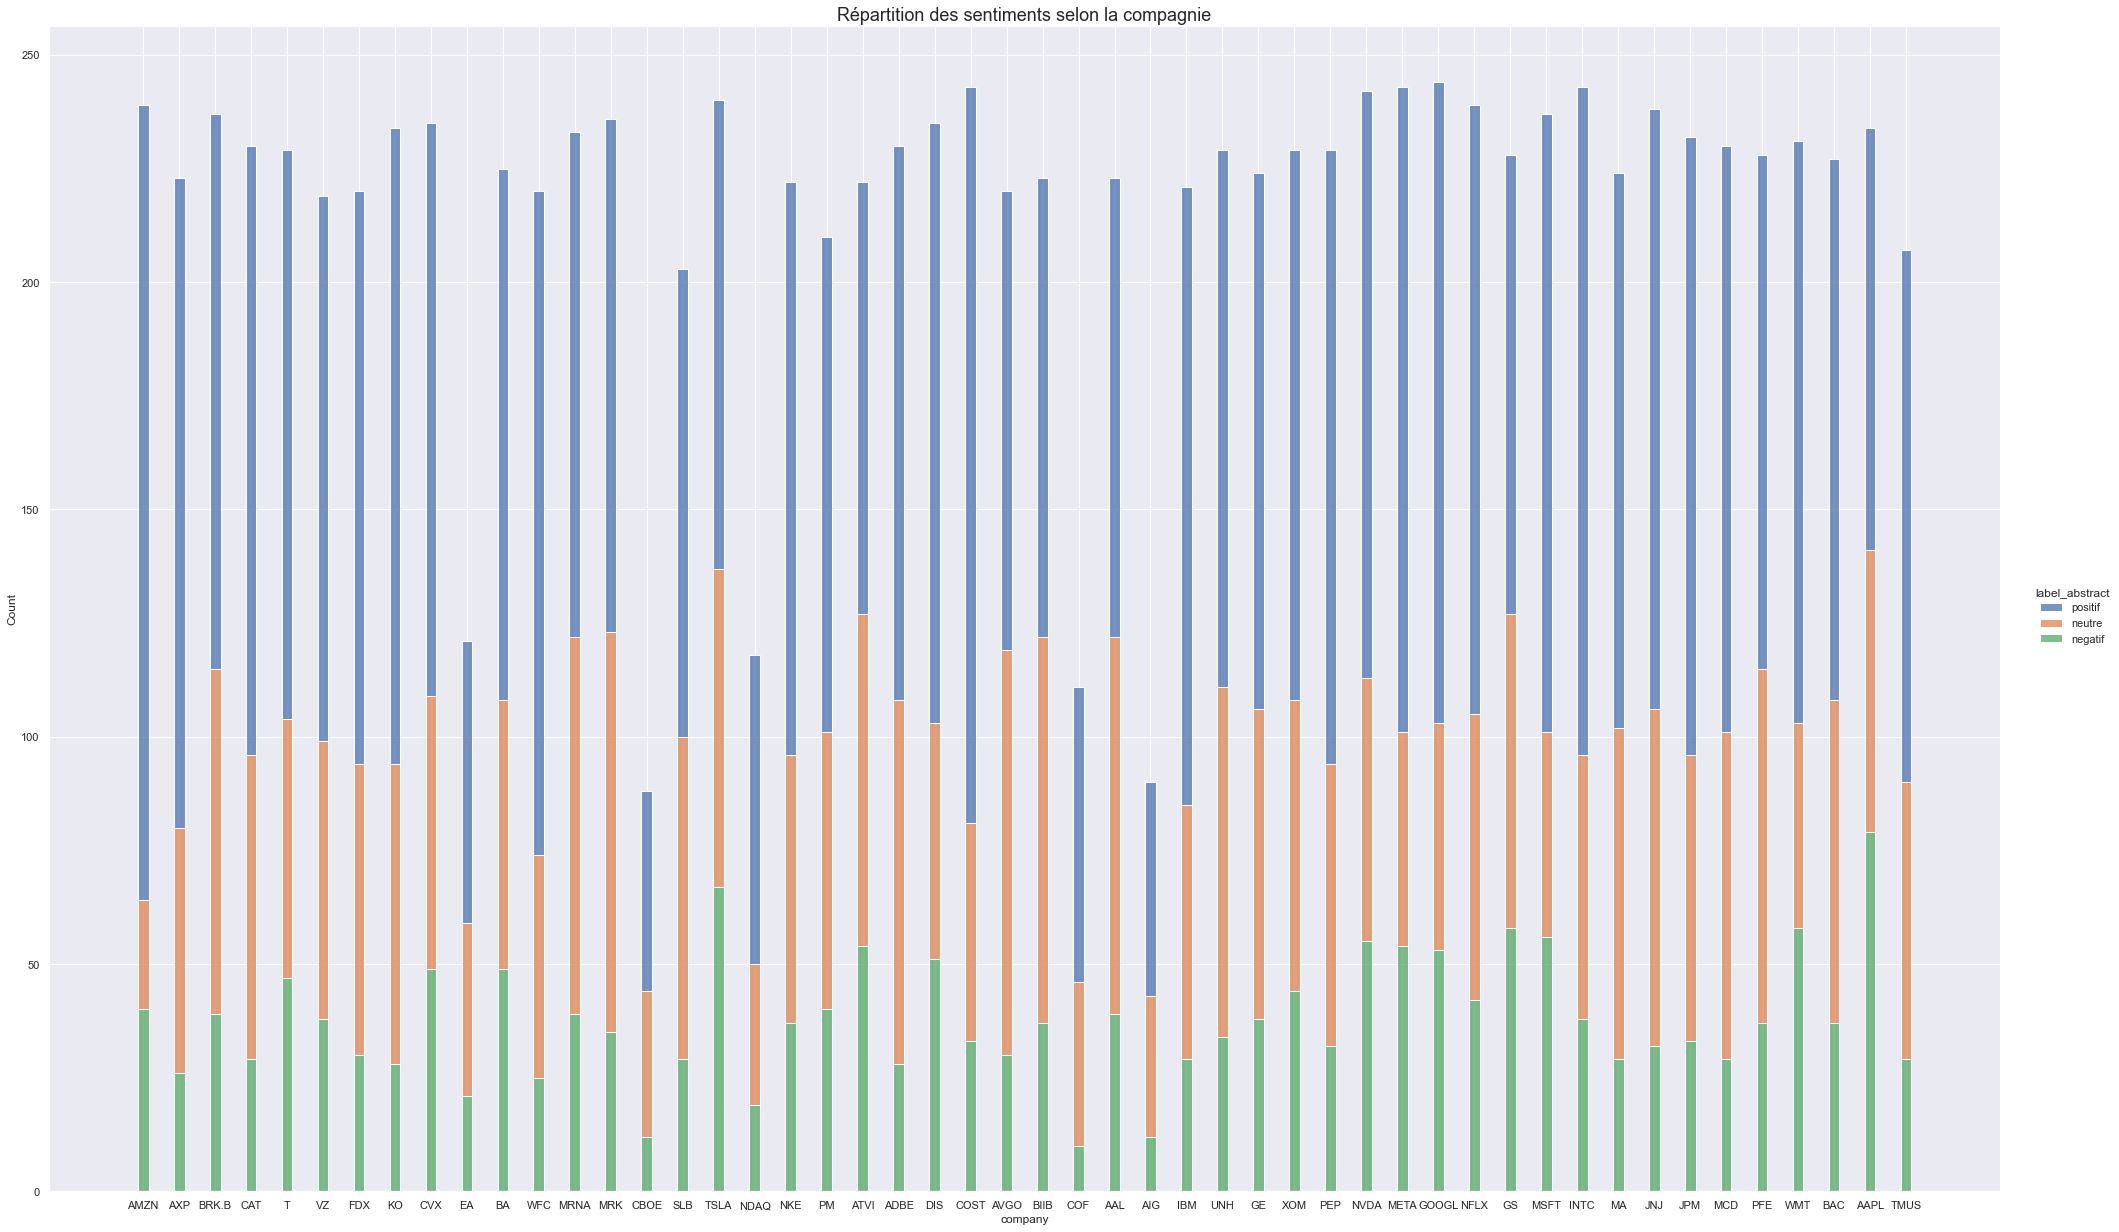

In [36]:
plt.figure(figsize=(100, 100))
cpalette = sns.diverging_palette(140, 10, n=3)
sns.displot(article_data.sort_values("label_abstract", ascending=False), x="company", hue="label_abstract", multiple="stack", shrink=0.3,height=17, aspect=20/12)


plt.title("Répartition des sentiments selon la compagnie",size=18)
plt.show()

Du graphique ci-dessus on constate que : 
- les articles positifs représentent la plus grande part des articles citant les companies du SP500 suivis des articles neutres puis négatifs.
- la répartition des articles positifs, neutres et négatifs semblent relativement similaire ce qui suggère une indépendance entre le type de sentiment et la companie choisie. Cela illustrerait donc une sorte de tendance de marché / sentiment global du marché. 

Nous allons donc étudier la relation entre la variable "label_abstact" qui nous renseigne sur le type de sentiment et la variable "company" qui nous renseigne sur le type de company du SP500 à l'aide d'un test d'indépendance du Khi-deux et d'un test de Cramer.

### Test du Chi-deux et Test de Cramer 

- Test du Chi-deux : Il s'agit d'un test qui compare la distribution des modalités de deux variables qualitatives. L'hypothèse du test est l'indépendance entre les deux variables. L'hypothèse est rejetée si la statistique calculée est supérieure à la valeur critique correspondante. On peut également utiliser la p-valeur qui est comparée à un seuil de significativité. Dans ce cas, l'hypothèse nulle est rejetée si cette p-valeur est inférieure au seuil. il permet donc de savoir si les variables entretiennent une relation, avec un degré de certitude plus ou moins grand. Par contre, il ne renseigne pas sur l’intensité de cette relation et la p-valeur est très sensible à la taille de l'échantillon.

- Test de Cramer : Plus le V de Cramer s’approche de 1, plus l’intensité de la relation est forte.


In [20]:
## Réalisation du test du Chi-deux 
khi2, pval , ddl , contingent_theorique = chi2_contingency(cont)
print('statistic: ',khi2, '\nP-value: ',pval ,'\nddl: ', ddl)

statistic:  366.4562920365898 
P-value:  1.2177330567602878e-32 
ddl:  98


In [21]:
## Fonction qui calcul le V de cramer 
def cramers(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = sum(crosstab.sum())
    return np.sqrt(chi2/(n*(min(crosstab.shape)-1)))

cramers(cont)

0.13002340060028644

Des résultats ci-dessus nous constatons que : 
- Au seuil de 5%, on rejette l'hypothèse nulle d'indépendance entre le type de sentiment et le type de companie du SP500 donc il existe toutefois une relation significative entre nos 2 variables quantitatives ( test du Chi-deux )
- L'intensité de la relation reste cependant très faible, le V de cramer étant relativement proche de 0. 